In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mne
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

**Load data from csv files.**

In [3]:
df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_S_feature.csv", header = 0)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sean\AppData\Local\Temp\ipykernel_24212\3915618476.py:1: SyntaxWarning: invalid escape sequence '\F'
  df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_24212\3915618476.py:2: SyntaxWarning: invalid escape sequence '\F'
  df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_24212\3915618476.py:3: SyntaxWarning: invalid escape sequence '\F'
  df_S = pd.read_csv("C:/SEAN/GA Tech Academics/

In [6]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


**Do some basic data preprocessing before performing feature selection.**

Fill in missing data with the mode of its column.

In [7]:
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

Drop the leftmost column of each dataframe because it is just an ID number.

In [8]:
df_A = df_A.iloc[:, 1:] 
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [9]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


**Feature selection:**

In [19]:
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    print("----------STARTING FEATURE SELECTION----------")
    y = df.iloc[:, -1]
    
    # Use recursive feature elimination with cross validation to reduce the dimensionality of the data for each EEG cap channel.
    
    print("----------STARTING RECURSIVE FEATURE ELIMINATION----------")
    start_column_index = 0
    num_features_kept_rfe = 0
    kept_columns_rfe = [] # list of names of columns that are kept

    for i in range(32):
        #print("EEG Cap Channel #", i)
        # Ignore the ratios (e.g. theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns
        
        # decision tree classifier
        dt_classifier = DecisionTreeClassifier()
        # recursive feature elimination with cross validation
        rfecv = RFECV(estimator = dt_classifier, min_features_to_select = 1, cv = StratifiedKFold(), scoring = 'accuracy')
        rfecv.fit(X, y)
        
        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        num_features_kept_rfe += rfecv.n_features_
        
        #print("Optimal number of features : %d" % rfecv.n_features_)
        #print("Columns kept in this iteration:", curr_columns[rfecv.support_])
        
        start_column_index += 14
    print("----------FINISHED RECURSIVE FEATURE ELIMINATION----------")
    
    df_after_rfe = df[kept_columns_rfe]
    print("number of features kept after recursive feature elimination:", num_features_kept_rfe)
    
    X = df_after_rfe
    curr_columns = X.columns

    # Use PCA to further reduce the dimensionality of the dataset.
    print("----------STARTING PCA----------")
    # Scale the data.
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_X= scaler.transform(X)

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit(scaled_X)
    pca_result = pca.transform(scaled_X)
    print("----------FINISHED PCA----------")
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    #print("explained variance ratio: ", explained_variance_ratio)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    #print("cumulative variance ratio: ", cumulative_variance_ratio)
    #print(cumulative_variance_ratio >= 0.8)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = curr_columns[:components_for_threshold]
    # print("Columns needed for", threshold * 100, "% explained variance:")
    # print(needed_columns)
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 201
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 26


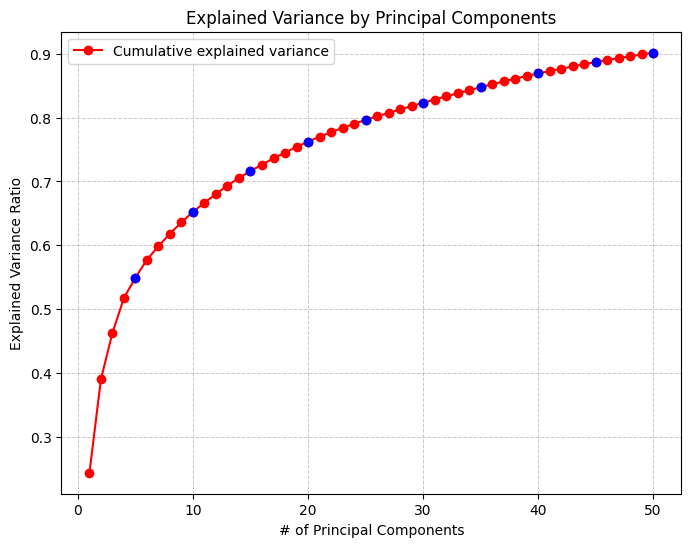

final kept columns:
    0.psd_delta  0.psd_alpha   0.psd_beta  0.psd_gamma   1.psd_delta  \
0  14850.830823  7910.065985  6950.560915  3047.582095   8934.671585   
1  14838.280527  7921.853628  8087.625726  2855.607519   4321.553687   
2   7143.715839  6245.775968  4200.151132  2838.155117  12595.467620   
3   7143.570136  7677.763201  4200.428316  2764.924613   8931.416757   
4  19573.432251  7663.019348  6509.398324  2423.619039  19269.407281   

   1.psd_gamma   2.psd_delta   2.psd_theta   2.psd_beta  2.psd_gamma  ...  \
0  2661.371734   8039.972356  10515.873942  5392.388155  2457.496229  ...   
1  2220.615506   2524.927423   9608.824749  5795.672908  2257.108195  ...   
2  2121.399887  11914.922522  16710.419354  4009.896543  1863.491634  ...   
3  2656.750004   7769.417844   4775.209063  3434.928351  2942.529008  ...   
4  2949.386556  18421.953705  14419.819060  4118.334851  2442.113285  ...   

    3.psd_theta  3.psd_alpha  3.psd_gamma  3.delta_rel_power  \
0  13819.209504  416

,0.psd_delta,0.psd_alpha,0.psd_beta,0.psd_gamma,1.psd_delta,1.psd_gamma,2.psd_delta,2.psd_theta,2.psd_beta,2.psd_gamma,...,3.psd_theta,3.psd_alpha,3.psd_gamma,3.delta_rel_power,3.theta_rel_power,4.psd_delta,4.psd_theta,4.psd_alpha,4.psd_beta,4.psd_gamma
0,14850.830823,7910.065985,6950.560915,3047.582095,8934.671585,2661.371734,8039.972356,10515.873942,5392.388155,2457.496229,...,13819.209504,4167.674765,2203.535042,0.083679,0.240264,13784.249158,16679.797843,6959.259471,5473.184804,2656.454642
1,14838.280527,7921.853628,8087.625726,2855.607519,4321.553687,2220.615506,2524.927423,9608.824749,5795.672908,2257.108195,...,13511.512183,4690.117540,2784.523275,0.097266,0.137924,13260.162339,16729.087706,6671.478508,7251.832429,2858.776325
2,7143.715839,6245.775968,4200.151132,2838.155117,12595.467620,2121.399887,11914.922522,16710.419354,4009.896543,1863.491634,...,12812.601964,4517.164653,2328.664450,0.135174,0.273329,7488.076404,11389.834726,6049.473059,4200.371424,2988.820818
3,7143.570136,7677.763201,4200.428316,2764.924613,8931.416757,2656.750004,7769.417844,4775.209063,3434.928351,2942.529008,...,6995.441331,5518.713670,2127.802416,0.075042,0.094432,6851.045175,9715.593586,7633.505250,3656.999796,2256.758518
4,19573.432251,7663.019348,6509.398324,2423.619039,19269.407281,2949.386556,18421.953705,14419.819060,4118.334851,2442.113285,...,12940.749857,7851.454295,1925.982216,0.208140,0.175183,13747.900917,12170.384434,8684.931093,5528.748439,1873.522054


In [17]:
df_A_processed = perform_feature_selection(df = df_A, variance_threshold=0.8)
df_A_processed.head()

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 154
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 23


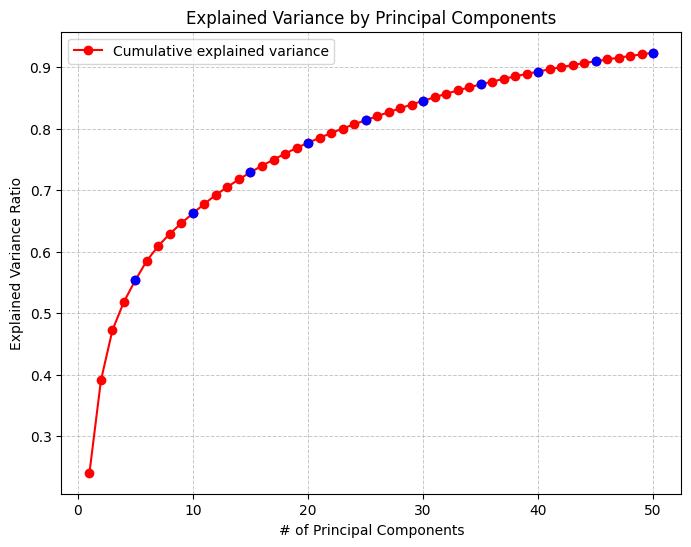

final kept columns:
    0.psd_delta    1.psd_beta   2.psd_delta   2.psd_theta   2.psd_alpha  \
0  28147.941302  12347.953811  34938.513792  33673.811526  21891.815170   
1  22618.036566  20171.707479  36819.225771  48968.262835  27692.934829   
2  43601.788099  18628.786426  66980.080825  32941.886308  24145.639485   
3  42496.747857  15681.375821  26387.037209  56582.287392  16128.611929   
4  26204.813555  21883.692721  46289.794364  25623.407990  20632.008824   

     2.psd_beta   2.psd_gamma  2.spectral_entropy_value  2.delta_rel_power  \
0  13745.843523  10897.486121                  4.922720           0.137969   
1  18368.858430  12772.993129                  4.849991           0.082822   
2  23829.755856   7233.061650                  5.046028           0.142731   
3  17794.462862  10245.559966                  4.993238           0.031872   
4  22215.895817  19825.541364                  4.079599           0.081317   

   2.theta_rel_power  ...  3.delta_rel_power   4.psd_delta  

,0.psd_delta,1.psd_beta,2.psd_delta,2.psd_theta,2.psd_alpha,2.psd_beta,2.psd_gamma,2.spectral_entropy_value,2.delta_rel_power,2.theta_rel_power,...,3.delta_rel_power,4.psd_delta,4.psd_alpha,4.psd_gamma,4.delta_rel_power,5.psd_delta,5.psd_theta,5.psd_alpha,5.psd_beta,5.psd_gamma
0,28147.941302,12347.953811,34938.513792,33673.811526,21891.815170,13745.843523,10897.486121,4.922720,0.137969,0.189380,...,0.133566,26988.404254,18965.198627,9528.718253,0.128433,16370.231319,15538.407764,13767.001272,5853.442135,4629.741077
1,22618.036566,20171.707479,36819.225771,48968.262835,27692.934829,18368.858430,12772.993129,4.849991,0.082822,0.144110,...,0.071854,12286.671681,13077.775287,7976.422647,0.048157,11010.032631,15484.868142,6198.527169,9502.346494,4993.142592
2,43601.788099,18628.786426,66980.080825,32941.886308,24145.639485,23829.755856,7233.061650,5.046028,0.142731,0.122136,...,0.140543,23145.298109,18216.623258,7330.350069,0.141043,14589.011408,15736.213638,13617.609789,9981.125948,5440.330895
3,42496.747857,15681.375821,26387.037209,56582.287392,16128.611929,17794.462862,10245.559966,4.993238,0.031872,0.220020,...,0.054072,28359.394878,17124.681107,8570.896216,0.073943,17022.803496,18922.574257,8836.577200,6813.136935,6737.046258
4,26204.813555,21883.692721,46289.794364,25623.407990,20632.008824,22215.895817,19825.541364,4.079599,0.081317,0.038631,...,0.076085,16449.479479,7261.552744,11341.236550,0.106252,11827.793849,8578.423712,3019.109910,8757.088312,9084.242048


In [18]:
df_M_processed = perform_feature_selection(df = df_M, variance_threshold=0.8)
df_M_processed.head()

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 212
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 22


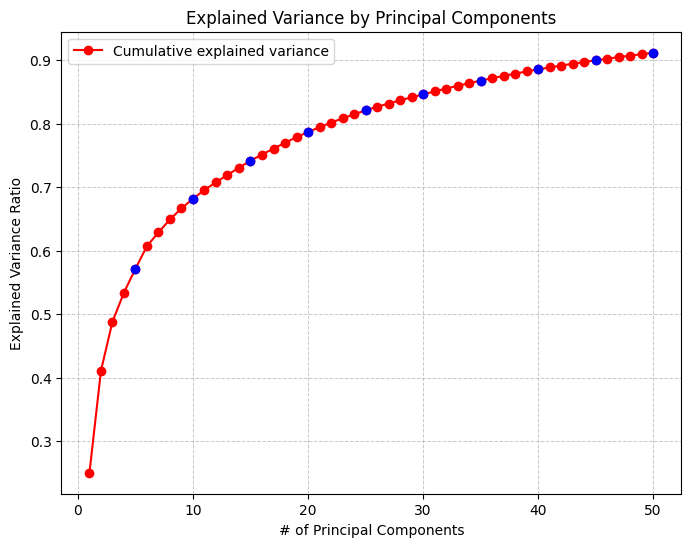

final kept columns:
    0.psd_delta  0.beta_rel_power   1.psd_delta   1.psd_theta  1.psd_alpha  \
0   9994.605340          0.355683   9257.775317   7265.036422  7690.433996   
1  14145.852129          0.280880  10435.260425   3644.720023  2613.103811   
2  10178.565631          0.233491   4620.447414  10058.027260  7519.625489   
3  16698.788741          0.210519  17008.405306   2634.528149  7967.808412   
4   5514.739540          0.287536   5870.110121   9069.907815  6995.540680   

    1.psd_beta  1.psd_gamma  1.spectral_entropy_value  1.delta_rel_power  \
0  5163.761781  1918.183035                  4.939184           0.135241   
1  2299.748262   801.173730                  4.803097           0.218845   
2  4332.200640   923.418221                  4.710522           0.061643   
3  3832.212650   977.771965                  4.304630           0.300044   
4  3168.696298   760.198454                  4.495017           0.066728   

   1.theta_rel_power  ...   2.psd_theta  2.psd_alpha  

,0.psd_delta,0.beta_rel_power,1.psd_delta,1.psd_theta,1.psd_alpha,1.psd_beta,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.theta_rel_power,...,2.psd_theta,2.psd_alpha,2.psd_gamma,2.spectral_entropy_value,2.delta_rel_power,2.alpha_rel_power,2.beta_rel_power,3.psd_delta,3.psd_theta,3.psd_beta
0,9994.605340,0.355683,9257.775317,7265.036422,7690.433996,5163.761781,1918.183035,4.939184,0.135241,0.135535,...,8405.860121,7705.936797,1654.873051,4.911795,0.141574,0.131389,0.389903,9661.907784,7575.225647,3342.981295
1,14145.852129,0.280880,10435.260425,3644.720023,2613.103811,2299.748262,801.173730,4.803097,0.218845,0.165130,...,2994.597561,3085.116293,729.303425,4.831397,0.183558,0.160544,0.348480,9912.301749,5373.831486,3596.341318
2,10178.565631,0.233491,4620.447414,10058.027260,7519.625489,4332.200640,923.418221,4.710522,0.061643,0.322946,...,10896.168504,6419.666259,897.488675,4.728050,0.059849,0.164598,0.360312,6328.599401,14417.491932,4935.154761
3,16698.788741,0.210519,17008.405306,2634.528149,7967.808412,3832.212650,977.771965,4.304630,0.300044,0.034743,...,3005.764882,6885.195474,808.399091,4.333768,0.275740,0.176540,0.410303,12758.430345,4609.960682,3178.899497
4,5514.739540,0.287536,5870.110121,9069.907815,6995.540680,3168.696298,760.198454,4.495017,0.066728,0.209294,...,9748.998366,6766.514201,1046.059848,4.624343,0.062009,0.265787,0.325384,6800.785099,9707.288972,3032.801001


In [20]:
df_S_processed = perform_feature_selection(df = df_S, variance_threshold=0.8)
df_S_processed.head()

**Implement the decision tree for detecting stress levels.**

**MAYBE COME BACK LATER TO THIS?**

Preprocess the data (There are 32 electrodes and 450 columns total, so 14 columns per electrode).

PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

FFS: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/


In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame: # COME BACK LATER
    data_arr = (data.to_numpy()).T
    channel_names = list(df_A.columns)  
    channel_types = ['eeg'] * len(channel_names) 
    info = mne.create_info(ch_names = channel_names, ch_types = channel_types)
    raw_arr = mne.io.RawArray(data_arr, info)
    raw_arr.filter(1, 40)
    
    # Perform ICA 
    ica = mne.preprocessing.ICA(n_components = 3)
    ica.fit(raw_arr)
    ica.exclude = ica.find_bads_eog(raw_arr)[0]
    raw_ica_cleaned = ica.apply(raw_arr.copy())
    
    # Convert cleaned data back into pandas DataFrame
    processed_data = (raw_ica_cleaned.get_data()).T
    df_processed = pd.DataFrame(processed_data, columns = channel_names)
    raw_ica_cleaned.plot()
    return df_processed
    